# COVID-19 Research Paper K-Means Clustering

Create clusters in the data using the abstracts of each paper, using the K-means clustering algorithm.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer

import re

In [2]:
"""Convert metadata.csv to a df_abstracts, which contains the sha and abstracts of every valid paper.
-read in metadata.csv to a df
-filter out rows without a full text file
-filter out rows with multiple corresponding full text files
-create df_abstracts, which contains sha and abstracts for all valid papers
"""

df = pd.read_csv("CORD-19-research-challenge/metadata.csv")
df_with_full = df.loc[df['has_full_text'] == True].drop(columns = 'has_full_text')

df_custom_license = df_with_full.loc[df_with_full['full_text_file'].str.match("custom_license")]
df_noncomm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("noncomm_use_subset")]
df_comm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("comm_use_subset")]
df_biorxiv_medrxiv = df_with_full.loc[df_with_full['full_text_file'].str.match("biorxiv_medrxiv")]

invalid_rows = []
for index, row in df_custom_license.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)

df_custom_license = df_custom_license.drop(invalid_rows)

invalid_rows = []
for index, row in df_noncomm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_noncomm_use_subset = df_noncomm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_comm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_comm_use_subset = df_comm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_biorxiv_medrxiv.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_biorxiv_medrxiv = df_biorxiv_medrxiv.drop(invalid_rows)

df_all = pd.concat([df_custom_license, df_noncomm_use_subset, df_comm_use_subset, df_biorxiv_medrxiv])

df_abstracts = df_all[['sha','abstract']]

df_abstracts.to_csv("abstracts.csv")

In [3]:
"""Take sample of rows from df_abstracts to reduce runtime"""

df_abstracts_partial = df_abstracts.sample(n=10000)
df_abstracts_partial = df_abstracts_partial.dropna()

In [4]:
"""Remove rows with bad input in abstract column"""

abstract_list = df_abstracts_partial["abstract"].values
abstract_list = [x for x in abstract_list if str(x) != 'nan']
type(abstract_list)

list

In [5]:
"""Check to make sure all abstract values are strings"""

bad_inputs = 0
for i in abstract_list:
    if type(i) != str:
        bad_inputs += 1
bad_inputs

0

In [6]:
""" Takes in abstract_list, returns abstract_list_stemmed, which contains the same list
of strings but with each word converted to reduce variability
"""

snowBallStemmer = SnowballStemmer("english")

abstract_list_stemmed = []

# adapted from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [snowBallStemmer.stem(word) for word in words]
    return words

for i in abstract_list:
    words_list = stemming_tokenizer(i)
    words_paragraph = ""
    for j in words_list:
        words_paragraph = words_paragraph + " " + j
    abstract_list_stemmed.append(words_paragraph)

In [100]:
"""Creares a df of TFIDF vectorized abstracts

TF-IDF (term frequency-inverse document frequency) is a statistical
measure that evaluates how relevant a word is to a document in a collection.

adapted from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

token_pattern=r'(?u)\b[A-Za-z]+\b' filters out non-alphabetical characters
"""

vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.9, max_features = 150, stop_words = 'english', token_pattern=r'(?u)\b[A-Za-z]+\b')
vectors = vectorizer.fit_transform(abstract_list_stemmed)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [101]:
df.drop(["abstract"], axis=1)

,acid,activ,acut,addit,age,analysi,anim,antibodi,antigen,antivir,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.0,0.000000,0.000000,0.0,0.119576,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.106107
1,0.0,0.000000,0.000000,0.0,0.000000,0.100705,0.000000,0.0,0.0,0.000000,...,0.000000,0.106382,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.510984,0.000000
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.688342,0.134370,0.000000
3,0.0,0.000000,0.094025,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.090763,0.000000,0.0,0.0,0.000000,0.056409,0.0,0.000000,0.000000,0.098629
4,0.0,0.060774,0.067697,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.241903,...,0.000000,0.134970,0.0,0.0,0.000000,0.040614,0.0,0.207566,0.040519,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8647,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.146132,0.0,0.0,0.000000,...,0.130981,0.067632,0.0,0.0,0.000000,0.000000,0.0,0.052004,0.040607,0.000000
8648,0.0,0.104444,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.089179,0.069634,0.000000
8649,0.0,0.000000,0.241414,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8650,0.0,0.163479,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.191021,0.327750,0.0,0.000000,0.000000,0.000000


In [102]:
df

,abstract,acid,activ,acut,addit,age,analysi,anim,antibodi,antigen,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.000000,0.0,0.000000,0.000000,0.0,0.119576,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.106107
1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.100705,0.000000,0.0,0.0,...,0.000000,0.106382,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.510984,0.000000
2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.688342,0.134370,0.000000
3,0.063195,0.0,0.000000,0.094025,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.090763,0.000000,0.0,0.0,0.000000,0.056409,0.0,0.000000,0.000000,0.098629
4,0.045500,0.0,0.060774,0.067697,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.134970,0.0,0.0,0.000000,0.040614,0.0,0.207566,0.040519,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8647,0.045599,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.146132,0.0,0.0,...,0.130981,0.067632,0.0,0.0,0.000000,0.000000,0.0,0.052004,0.040607,0.000000
8648,0.000000,0.0,0.104444,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.089179,0.069634,0.000000
8649,0.000000,0.0,0.000000,0.241414,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8650,0.122394,0.0,0.163479,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.191021,0.327750,0.0,0.000000,0.000000,0.000000


In [143]:
"""Apply PCA to normalized TF-IDF document vectors to reduce number of dimensions to help with K-means clustering.
Used a threshold value of 0.85 to ensure the reduced dimension vectors account for 85% of the variance."""

# adapted from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 0.85)
standardized_values = StandardScaler().fit_transform(df.values)
principal_components = pca.fit_transform(standardized_values)
reduced_df = pd.DataFrame(data = principal_components)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,1.445002,1.136723,-1.547224,2.236440,1.347156,-0.847369,1.535791,-2.371424,-0.766536,-1.218595,...,0.379363,0.233713,0.619252,-0.689730,-0.716915,-1.304487,-0.792272,0.129020,-1.898335,-0.226735
1,0.619138,-1.914639,-2.710916,-1.408106,-2.001737,-0.270343,-0.288470,0.497286,-0.152644,0.020602,...,0.775437,0.937145,0.272269,-0.430881,-1.059652,0.166533,0.794515,0.571797,-0.007729,0.330517
2,-2.092792,-0.232987,-0.851353,2.036624,-1.482336,-3.645334,-0.543961,1.025838,-0.396246,1.705637,...,-0.065657,0.262839,1.805774,-0.601937,0.724834,-0.404500,-0.204745,-0.764932,-0.005179,-0.313400
3,0.548602,-0.126590,-0.273953,-0.828457,2.702064,0.647453,-0.370913,-1.580680,-0.419954,-0.466631,...,0.056739,-0.054776,2.217479,-1.142580,-0.766926,0.981758,-1.480731,-1.698969,0.381644,0.750134
4,-1.291995,-0.552119,-2.056291,3.240747,2.321890,0.582616,1.796029,1.998923,-0.190710,0.256173,...,-0.646380,0.355537,-0.661735,0.737982,0.538292,-0.106441,0.737644,-0.525245,0.275629,-0.012834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8647,1.381074,-2.331044,-2.790624,-2.865836,-2.432774,0.651569,0.515581,1.242386,-0.405469,-0.673317,...,-1.074509,-0.447994,0.844855,-1.959941,-1.718140,1.793277,0.612287,-0.416354,0.851418,-1.125390
8648,-1.234842,0.736422,3.352968,2.964660,-1.693551,1.858264,-1.509443,1.206644,-0.392488,0.714741,...,-0.829440,-0.027329,-0.698106,1.660571,-1.447591,0.872027,0.866234,-0.080978,-0.238502,-0.567891
8649,2.331431,1.318319,-3.127391,5.104314,2.906390,0.925383,1.201481,-0.761017,-0.605158,-1.772652,...,-0.920441,-0.609081,0.284318,0.413254,-0.249127,0.288498,-0.082902,-0.062448,-0.319214,0.292320
8650,-2.597198,0.317078,-0.120470,-2.101465,1.330155,-1.158694,1.839156,-1.583499,1.145249,-0.916328,...,1.304120,0.493224,0.253383,1.545290,0.676753,-0.871046,-0.865960,1.198252,1.777063,0.760211


In [144]:
"""100 most relevant features"""

(reduced_df.columns)

RangeIndex(start=0, stop=113, step=1)

sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity


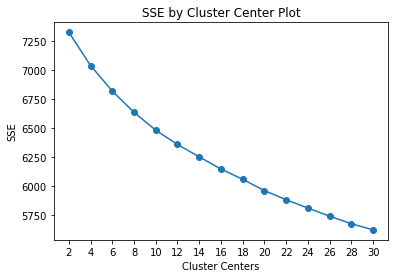

In [145]:
"""Creates an elbow plot to identify the ideal number of clusters based on sum of squared errors

copied from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
"""

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, n_init=20).fit(data).inertia_)
        #sse.append(MiniBatchKMeans(n_clusters=k, batch_size=2048, random_state=20).fit(data).inertia_)
        #print('Fit {} clusters'.format(k))
        print("sanity")
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(df, 30)

In [56]:
"""Displays an example of the TFIDF vector for a single paper"""

row_dict = df.loc[ 0 , : ].to_dict()

from collections import OrderedDict

dd = OrderedDict(sorted(row_dict.items(), key=lambda x: x[1], reverse=True))
dd

OrderedDict([('pneumonia', 0.6580116228373272),
             ('respiratori', 0.3646678559977498),
             ('virus', 0.25960227894247506),
             ('patient', 0.25490558673758845),
             ('detect', 0.24241171178019072),
             ('sever', 0.1751636868661802),
             ('viral', 0.1653740029139932),
             ('day', 0.12412072995574065),
             ('rate', 0.11978189153563867),
             ('influenza', 0.11527514711971464),
             ('case', 0.10604050861873779),
             ('increas', 0.09512975099997341),
             ('caus', 0.09465517162518916),
             ('import', 0.09378114427243181),
             ('signific', 0.09229416883054485),
             ('includ', 0.08895830398128438),
             ('studi', 0.06642895310384536),
             ('infect', 0.06580282871160935),
             ('b', 0.06498371200303843),
             ('hospit', 0.06429372309904739),
             ('age', 0.06374527537839919),
             ('p', 0.06316671931334869),
   

In [106]:
"""Adds assigned cluster cloumn to df_partial_abstracts."""

clusters = KMeans(n_clusters=12).fit_predict(df)

df_abstracts_partial["cluster"] = clusters
df_abstracts_partial.sort_values("cluster")

,sha,abstract,cluster
18266,cb0831902de1f8a19992ff86bcc7e15fa2d7d687,Reanalysis of the epidemic curve from the init...,0
3196,6ec9b584f902c9b5671dac9b59077d0e7c12084b,Abstract Infectious diseases are caused by mic...,0
3206,8317e1b11fa98c1855020688ead90baa5e8efdd1,Abstract Bioaugmentation is an eco-friendly an...,0
25003,b4236b54e869414c7cb19814dc2e6216a9573c0e,This article describes methods of treatment fo...,0
12015,235e1bab19239e4ee21dc2c00bb0df4c1667e9dc,Abstract This paper describes a method to prov...,0
...,...,...,...
39674,e4f66cfdaf836895e7d37941223f11ebc41dbb57,Synthetic biology based diagnostic technologie...,11
22818,bfe634ff1fa0e8f0a43c1bd5fa6e0b5bd17705ee,"Since 2010, the variant porcine epidemic diarr...",11
43279,c66be1e891285a777b15ba49e685452fed6ee837,The avian coronavirus (AvCoV) infectious bronc...,11
10806,96071f2ddd4192c50ff7bbe2c72b08f6d7210b2c,Abstract From an aqueous decoction of the trad...,11


In [142]:
clustercounts = df_abstracts_partial[["abstract", "cluster"]]
clustercounts = clustercounts.groupby("cluster", as_index=False).count().sort_values("cluster", ascending=True)
clustercounts

,cluster,abstract
0,0,2240
1,1,852
2,2,385
3,3,569
4,4,474
5,5,711
6,6,638
7,7,555
8,8,328
9,9,889


([<matplotlib.axis.XTick at 0x1a21f96110>,
 <a list of 12 Text xticklabel objects>)

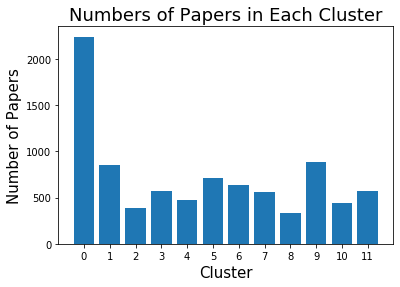

In [139]:
# plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('cluster', 'abstract', data=clustercounts)
plt.xlabel("Cluster", size=15)
plt.ylabel("Number of Papers", size=15)
plt.title("Numbers of Papers in Each Cluster", size=18)
plt.xticks(clustercounts["cluster"].values)

In [109]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(df, clusters)

TypeError: '(array([8345, 5170, 8411, ..., 1868, 1404, 1094]),)' is an invalid key

In [110]:
range(df.shape[0])

range(0, 8652)